# TASEPy applications

The totally asymmetric simple exclusion process (TASEP) has been introduced as a model of biopolymerization, where the mRNA is represented as a one-dimensional lattice with discrete sites corresponding to codons. The dynamics of ribosomes on the mRNA is modeled with particles moving from site to site on the lattice.

In [1]:
# import methods from TASEPy

from TASEPy import psa_compute
from TASEPy import local_density
from TASEPy import mean_density
from TASEPy import current

# to measure computation time
import time

## Estimating translation initiation rate $\alpha$ from polysome profiling data

As an application of the TASEPy package, we demonstrate how to infer the initiation rate $\alpha$ when the hopping rates $\omega_i$ (representing codon-dependent ribosome speed) and the mean density $\rho$ (indicating the average number of ribosomes divided by the length of the mRNA in codon units) are known. The mean ribosome density can be measured using polysome profiling, and the codon-dependent hopping rates have been estimated based on tRNA concentrations.

Thus, by predicring $\rho(\alpha)$ with TASEPy and with the experimental value $\rho_\textrm{exp}$, we can infer the value of $\alpha$. First, we import a file containing hopping rates for the YAL008W gene of *S. cerevisiae*, which have been estimated in Ciandrini L, Stansfield I, Romano MC (2013) *Ribosome Traffic on mRNAs Maps to Gene Ontology: Genome-wide Quantification of Translation Initiation Rates and Polysome Size Regulation*. PLoS Comput Biol 9(1): e1002866. https://doi.org/10.1371/journal.pcbi.1002866

In [2]:
# imports hopping rates YAL008W_rates.dat

with open('applications/YAL008W_rates.dat', 'r') as file:
    rates = [float(line.split()[1]) for line in file]

Next, we set particle size $\ell=9$ as in the reference above, and choose the order of PSA $K=3$. This takes about 11 seconds to solve on a laptop with Intel i7-8565U CPU and 16 GB of RAM, and less than 7 seconds on an Apple M1 Pro with 32 GB of RAM.

In [3]:
# computes the PSA for order K = 3

L = len(rates) # lattice size
ll = 9 # particle size
K = 3 # maximum PSA order

print('Lattice size:',L,'codons')

start = time.time()
rhocoeff, Jcoeff = psa_compute(rates, K, ll)
end = time.time()
print('Computation time:',round(end-start,3),'seconds')

Lattice size: 198 codons
Computation time: 6.667 seconds


We then need to compute the mean density coefficients $\rho_n=\sum_{i=1}^{L}\rho_{i,n}/L$ for $n=0,\dots,K$ as in Eq.(25c) of the paper introducing the algorothm used in TASEPy (Ciandrini, Crisostomo and Szavits-Nossan 2023).

In [4]:
# computes mean density coefficients

mean_rhocoeff = []
for order in range(0,K+1):
    rhocoeff_sum = 0
    for site in range(L):
        rhocoeff_sum += rhocoeff[site][order]
    mean_rhocoeff.append(rhocoeff_sum/L)
print(mean_rhocoeff)

[0.0, 0.1806069864721105, -0.20947619500711065, 0.32647921092495436]


Next, we set up the function whose root we want to find: $f(\alpha)=\rho(\alpha)-\rho_{\text{exp}}$, where $\rho(\alpha)\approx\sum_{n=0}^{K}\rho_n \alpha^n$ is the mean density computed using TASEPy for a given value of the initiation rate $\alpha$, and $\rho_{\text{exp}}$ is the mean density measured experimentally, see the cited Ciandrini et (2013) reference for more details. Since $f(\alpha)$ is a polynomial, we can also find its derivative, in which case we can use the Newton-Raphson method for solving $f(\alpha)=0$.

In [5]:
# root finding algorithm
from scipy import optimize

# experimental mean density
rhoexp = 0.023226

# in the functions below x is the initation rate (alpha)
def f(x,a):
    result = -rhoexp
    for order,coeff in enumerate(a):
        result += coeff * x**order
    return result

def fprime(x,a):
    result = 0
    for order,coeff in enumerate(a):
        if order > 0:
            result += coeff * order * x**(order-1)
    return result

As the initial guess, we can use the first-order approximation of the PSA, $\rho_{\text{exp}}\approx \rho_{1}\alpha$.

In [6]:
# initial guess
alpha0 = rhoexp/mean_rhocoeff[1]
print('Initial value:',alpha0)

Initial value: 0.12859967631200458


Finally, we call the optimize function from the scipy package to find the root.

In [7]:
alpha = optimize.newton(f, alpha0, fprime, args=(mean_rhocoeff,))
print('Optimal value:',alpha)

Optimal value: 0.14818676243771686


This value is very close to the one obtained from stochastic simulations in the cited Ciandrini et al (2013) paper. The relative error is about 1.5\%.

In [8]:
# value reported in Ciandrini L, Stansfield I, Romano MC (2013) 
# Ribosome Traffic on mRNAs Maps to Gene Ontology: Genome-wide 
# Quantification of Translation Initiation Rates and Polysome 
# Size Regulation. PLoS Comput Biol 9(1): e1002866. 
# https://doi.org/10.1371/journal.pcbi.1002866

alpha_paper = 0.150499
per_err = 100 * abs(alpha_paper-alpha)/alpha_paper
print('Relative percentage error: ',per_err)

Relative percentage error:  1.5363806817873418


---

## Estimating translation elongation rates from ribosome profiling data

We now solve a different problem, in which the mean density $\rho_{\text{exp}}$ is known, as well as the local densities $\rho_{i}$ for $i=1,\dots,L$, but the elongation rates $\omega_i$ for $i=1,\dots,L$ and the initiation rate $\alpha$ are unknown. This problem is inspired by experimental ribosome profiling data, in which the occupancy of the ribosomes (particles) is known on each codon (lattice site). Here we present a simplifed version of that, and assume that the ratio $\rho_i/\rho$ is known. 

The approach is explained in detail in J. Szavits-Nossan , L. Ciandrini (2020) *Inferring efficiency of translation initiation and elongation from ribosome profiling*. Nucleic Acids Research 48(17):9478-9490, https://doi.org/10.1093/nar/gkaa678, which makes use of the PSA approximation (up to order $n=3$).

First, we note that since the local density $\rho_i$ is dimensionless, we can only find the ratios $\omega_i/\alpha$ for $i=1,\dots,L$, not the absolute elongation rates. Let us denote by $\kappa_i$ the ratio $\omega_i/\alpha$, $\kappa_i=\omega_i/\alpha$. We want to find $\kappa_1,\dots,\kappa_L$ such that
\begin{equation}
    \rho_i(\kappa_1,\dots,\kappa_L)=\rho_{i,\text{exp}},\quad i=1,\dots,L, \tag{1}
\end{equation}

where the left-hand side is the local density predicted by the TASEP, and the right-hand side is the experimentally measured density. This problem can be solved by minimising the objective function
\begin{equation}
    D(\kappa_1,\dots,\kappa_L)=\sqrt{\frac{\sum_{i=1}^{L}[\rho_{i}(\kappa_1,\dots,\kappa_L)-\rho_{i,\text{exp}}]^2}{L}}, \tag{2}
\end{equation}

which is also known as the root mean square deviation (RMSD). Here we demonstrate how to solve this problem using TASEPy and SciPy repositories. We will not use real ribosome profiling data, instead we use mock data obtained using stochastic simulations for a given set of randomly selected hopping rates $\omega_i$ and a given value of the initiation rate $\alpha$. We will then use TASEPy to restore the values of $\kappa_i=\omega_i/\alpha$ and compare them to the original ones.

In [9]:
# import random number generator
from statistics import random

# import minimization algoritm
from scipy import optimize

In order to demonstrate the methodology, we select a relatively small lattice size $L=20$ and $\ell=1$. 

In [10]:
# declare parameters

# lattice size
L = 20

# particle size (in lattice sites)
ll = 1

# list of particle hopping rates selected randomly from interval [1,10]
# unless changing the seed, the outcome can be compared to the stochastic simulations
# stored in this directory
random_seed = random.seed(1234)
rates = [random.uniform(1,10) for site in range(L)] 
 
# maximum order of the PSA
K = 3

# initiation rate
alpha = 0.2

The rates are stored in the file *applications/rates_L20.dat*.

In [11]:
with open('applications/rates_L20.dat', 'w') as file:
    n = 0
    for rate in rates:
        if n < L-1: 
            file.write(str(rate)+'\n')
        else:
            file.write(str(rate))
        n += 1

For these set of parameters, we obtained the local densities using stochastic simulations, which are stored in the file *applications/rho_a02_L20_ll1_iter1e6.dat*.

In [12]:
# imports local densities (mock data)

with open('applications/rho_a02_L20_ll1_iter1e6.dat', 'r') as file:
    rhoexp = [float(line) for line in file]

Let us see first how the local density obtained using TASEPy with original hopping rates compares to the one obtained by stochastic simulations. For real data, we can only check this at the end with the inferred rates.

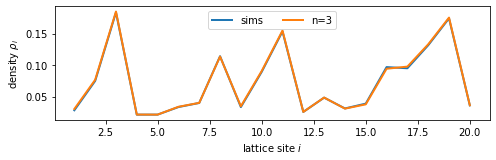

In [13]:
kappa_original = [rate/alpha for rate in rates]

rhocoeff, Jcoeff = psa_compute(kappa_original, K, ll)
rho = local_density(rhocoeff, 1.0)[-1]

import matplotlib.pyplot as plt

# Create a figure 
plt.figure(figsize=(7,7/3))

# Plot the data

sites = [x + 1 for x in range(L)]
plt.plot(sites, rhoexp, linewidth=2, label='sims')
plt.plot(sites, rho, linewidth=2, label='n='+str(K))

plt.xlabel(r'lattice site $i$', fontsize=10)
plt.ylabel(r'density $\rho_{i}$', fontsize=10)

plt.legend(loc='best',ncol=2)
plt.tight_layout()

plt.show()

The order of $K=3$ is applicable to our problem, so we proceed with the minimization procedure. 

For the initial values of the ratios $\kappa_i$, we employ the mean-field approximation, which ignores correlations between neighbouring lattice sites, leading to the following set of equations:
\begin{equation}
    \kappa_i=\frac{\left(1-\sum_{s=1}^{\ell}\rho_{s,\text{exp}}\right)\left(1-\sum_{s=1}^{\ell}\rho_{i+s,\text{exp}}+\rho_{i+\ell,\text{exp}}\right)}{\rho_{i,exp}\left(1-\sum_{s=1}^{\ell}\rho_{s,\text{exp}}\right)},\quad i=1,\dots,L-\ell \tag{3}
\end{equation}

\begin{equation}
    \kappa_i=\frac{\left(1-\sum_{s=1}^{\ell}\rho_{s,\text{exp}}\right)}{\rho_{i,exp}},\quad i=L-\ell+1,\dots,L . \tag{4}
\end{equation}

In [14]:
kappa0 = []
for site in range(L):
    sum1 = sum(rhoexp[:ll])
    if site < L-ll:
        sum2 = sum(rhoexp[site:site+ll+1])
        kappa_site = (1-sum1)*(1-sum2+rhoexp[site+ll])/(rhoexp[site]*(1-sum1))
    else:
        kappa_site = (1-sum1)/rhoexp[site]
    kappa0.append(kappa_site)

We can check how close these initial values are to the real ones: they are close but there are obvious deviations.

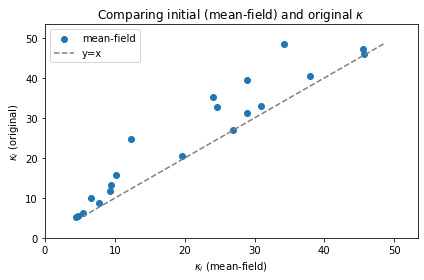

In [15]:
# Create a figure 
plt.figure(figsize=(6,4))

# Plot the data

min_kappa = min(rates)/alpha
max_kappa = max(rates)/alpha
linearx = [min_kappa,max_kappa]

plt.scatter(kappa0, kappa_original,label='mean-field')
plt.plot(linearx, linearx, linestyle='--', color='gray',label='y=x')

plt.xlim(0,1.1*max(rates)/alpha)
plt.ylim(0,1.1*max(rates)/alpha)

plt.xlabel(r'$\kappa_i$ (mean-field)', fontsize=10)
plt.ylabel(r'$\kappa_i$ (original)', fontsize=10)

# Set the title
plt.title(r'Comparing initial (mean-field) and original $\kappa$', fontsize=12)

plt.legend(loc='best')
plt.tight_layout()

plt.show()

We now set up the minimisation procedure using the Powell method and `scipy.optimize.minimize`, which has an option to set up parameter bounds. In our case, we know that $0<\kappa_i<\infty$ for $i=1,\dots,L$. In practice, we can use smaller bounds, e.g. $10^{-2}$ instead of $0$ and $10^{5}$ instead of $\infty$. This optimization procedure takes about XX minutes on a laptop with Intel i7-8565U CPU and 16 GB of RAM, and less than minutes on an Apple M1 Pro with 32 GB of RAM.

In [16]:
import numpy as np
import math

# set up the objective function
def fun(kappa, K, ll, rhoexp):
    rhocoeff, Jcoeff = psa_compute(kappa, K, ll)
    rho = local_density(rhocoeff, 1.0)[-1]
    D = 0
    for i in range(L):
        D += (rho[i]-rhoexp[i])**2
    D = math.sqrt(D/L)
    return D

# set up linear constraint
A = np.identity(L)
lower = np.array([1e-2 for site in range(L)]) # lower bound
upper = np.array([1e5 for site in range(L)]) # upper bound
cons = optimize.LinearConstraint(A, lower, upper)

# set up bounds (must be tuples)
bnds = ((1e-2,1e5),)*L

In [17]:
print('Started optimization...',end=" ")
start = time.time()

# COBYLA method (constrained optimization, derivative-free)
#kappa = optimize.minimize(fun, kappa0, args=(K, ll, rhoexp), method='COBYLA', constraints=cons, options={'maxiter':5e4,'disp': True})

# Powell method (bounded optimization, derivative-free)
kappa = optimize.minimize(fun, kappa0, args=(K, ll, rhoexp), method='Powell', bounds=bnds, options={'ftol': 1e-3, 'xtol': 1e-3, 'disp': True})

print('Done.')
end = time.time()
print('Computation time:',round(end-start,3),'seconds')

# print info
kappa

Started optimization... Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 17
         Function evaluations: 10180
Done.
Computation time: 119.315 seconds


   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.18265662e-02, -8.19715201e-04,  8.03300817e-05,
        -3.84603702e-04,  3.06382355e-04,  1.16464574e-04,
         3.02547635e-04,  2.56334658e-05,  5.73812542e-04,
         5.38488255

Having inferred the set of $\kappa_i$'s `kappa` from the particle density profile, we now compare them to the `kappa_original` which have been used to produce the density profile with stochastic simulations.

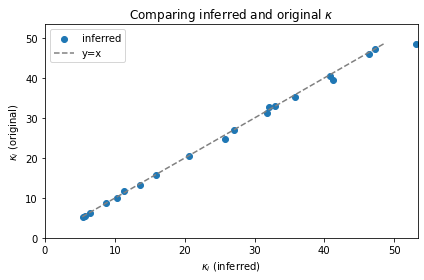

In [18]:
# Create a figure 
plt.figure(figsize=(6,4))

# Plot the data

min_kappa = min(rates)/alpha
max_kappa = max(rates)/alpha
linearx = [min_kappa,max_kappa]

plt.scatter(kappa.x, kappa_original,label='inferred')
plt.plot(linearx, linearx, linestyle='--', color='gray',label='y=x')

plt.xlim(0,1.1*max(rates)/alpha)
plt.ylim(0,1.1*max(rates)/alpha)

plt.xlabel(r'$\kappa_i$ (inferred)', fontsize=10)
plt.ylabel(r'$\kappa_i$ (original)', fontsize=10)

# Set the title
plt.title(r'Comparing inferred and original $\kappa$', fontsize=12)

plt.legend(loc='best')
plt.tight_layout()

plt.show()

We store the inferred ratios $\kappa_i$ for $i=1,\dots,L$ in the file *applications/rates_L20-inferred.dat*.

In [19]:
with open('applications/kappa_L20-inferred.dat', 'w') as file:
    n = 0
    for rate in kappa.x:
        if n < L-1: 
            file.write(str(rate)+'\n')
        else:
            file.write(str(rate))
        n += 1

We also save all the information from the minimization procedure in a separate file *kappa_L20-minimize.log*, except the inferred ratios.

In [20]:
dict_keys = []
dict_values = []
for keys, value in kappa.items():
    dict_keys.append(keys)
    dict_values.append(value)
    
with open('applications/kappa_L20-minimize.log', 'w') as file:
    for i in range(1,len(dict_keys)):
        file.write(dict_keys[i]+' : '+str(dict_values[i])+'\n')